# Automatic Outlier Detection


## 1. Imports

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

## 2. Load and Pre-process data

In [2]:
data = pd.read_csv("../data/cleaned_data.csv")
features = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
            'relative_velocity', 'miss_distance']

X = data[features]

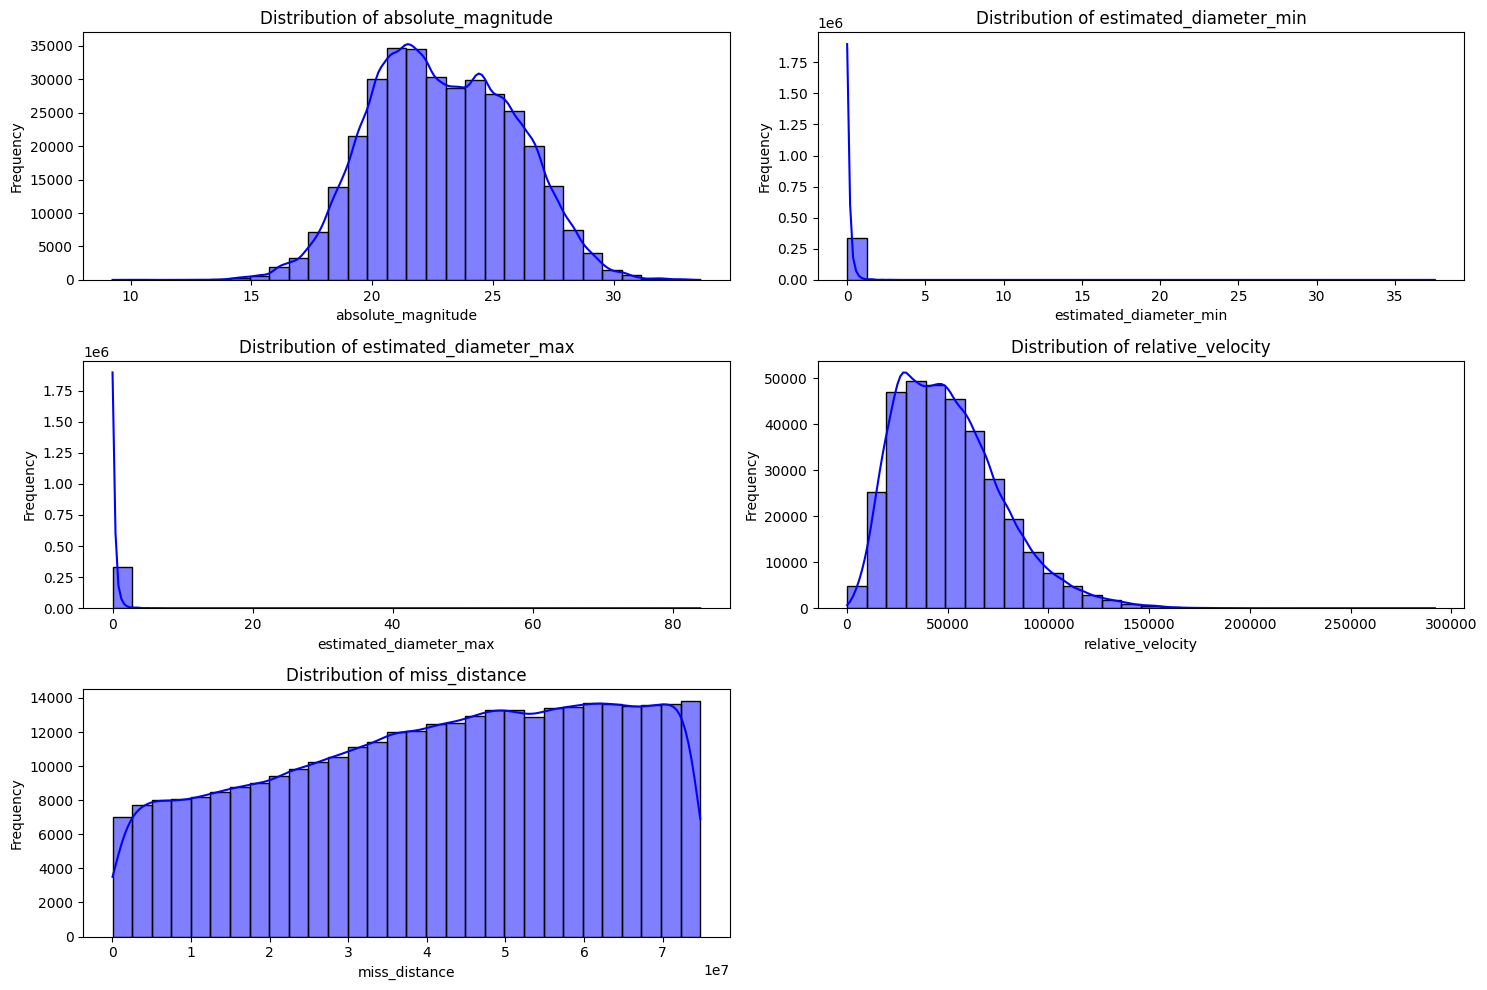

In [10]:
# Distribution of all the features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[feature], kde=True, color='blue', bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

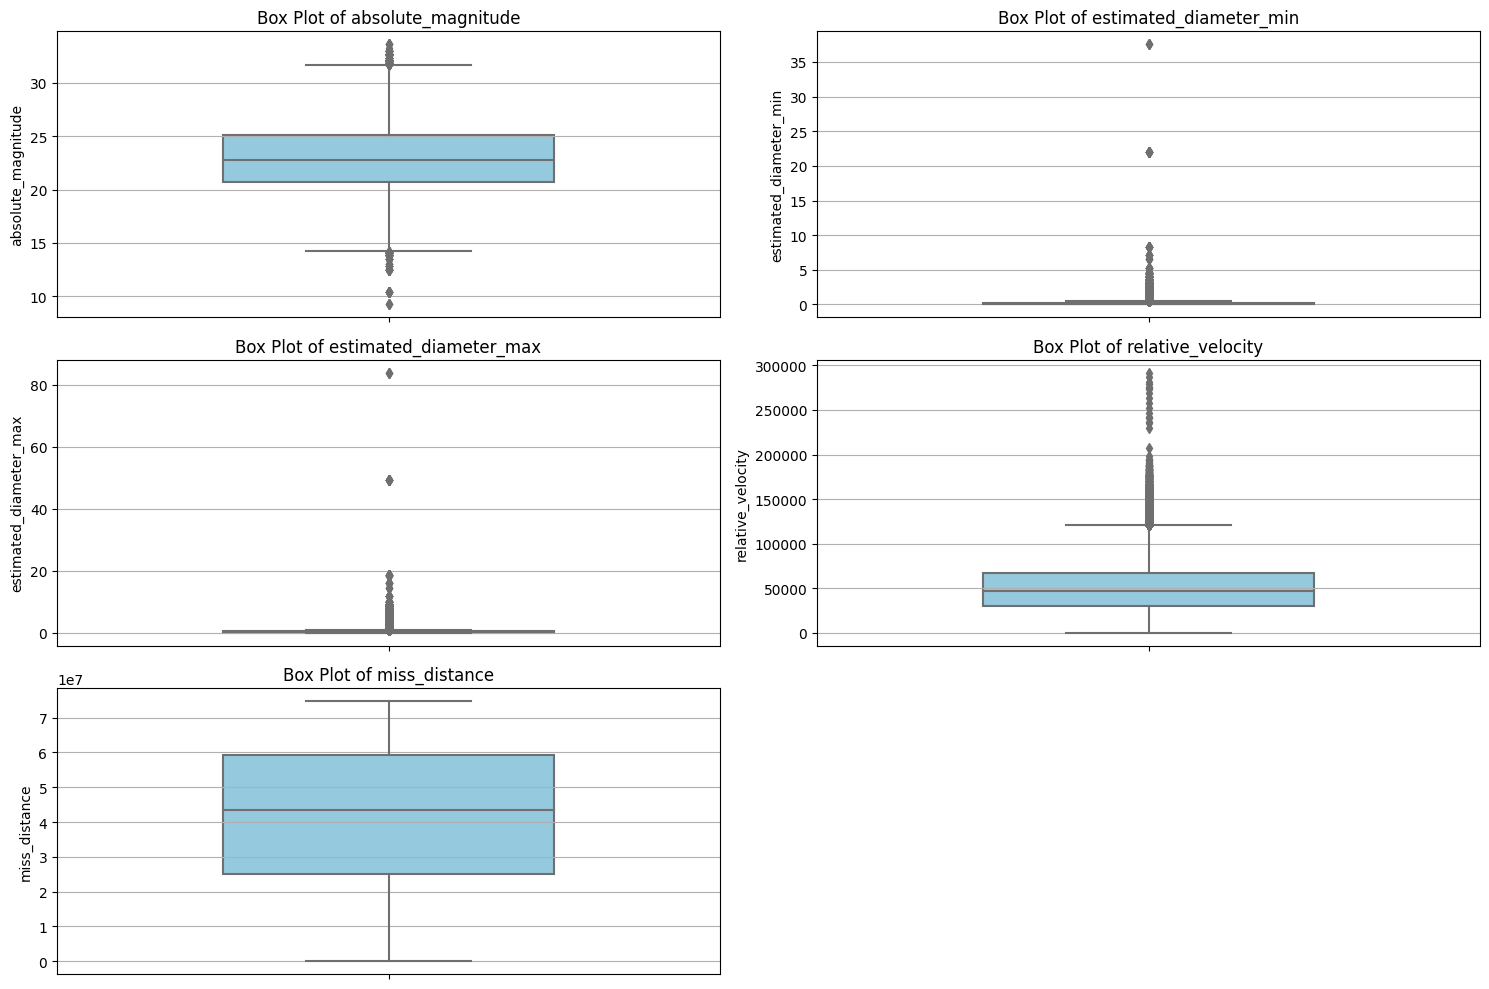

In [16]:
# Plot box plots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=data[feature], color='skyblue', width=0.5)
    plt.title(f"Box Plot of {feature}")
    plt.ylabel(feature)
    plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [3]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_scaled.shape

(338171, 5)

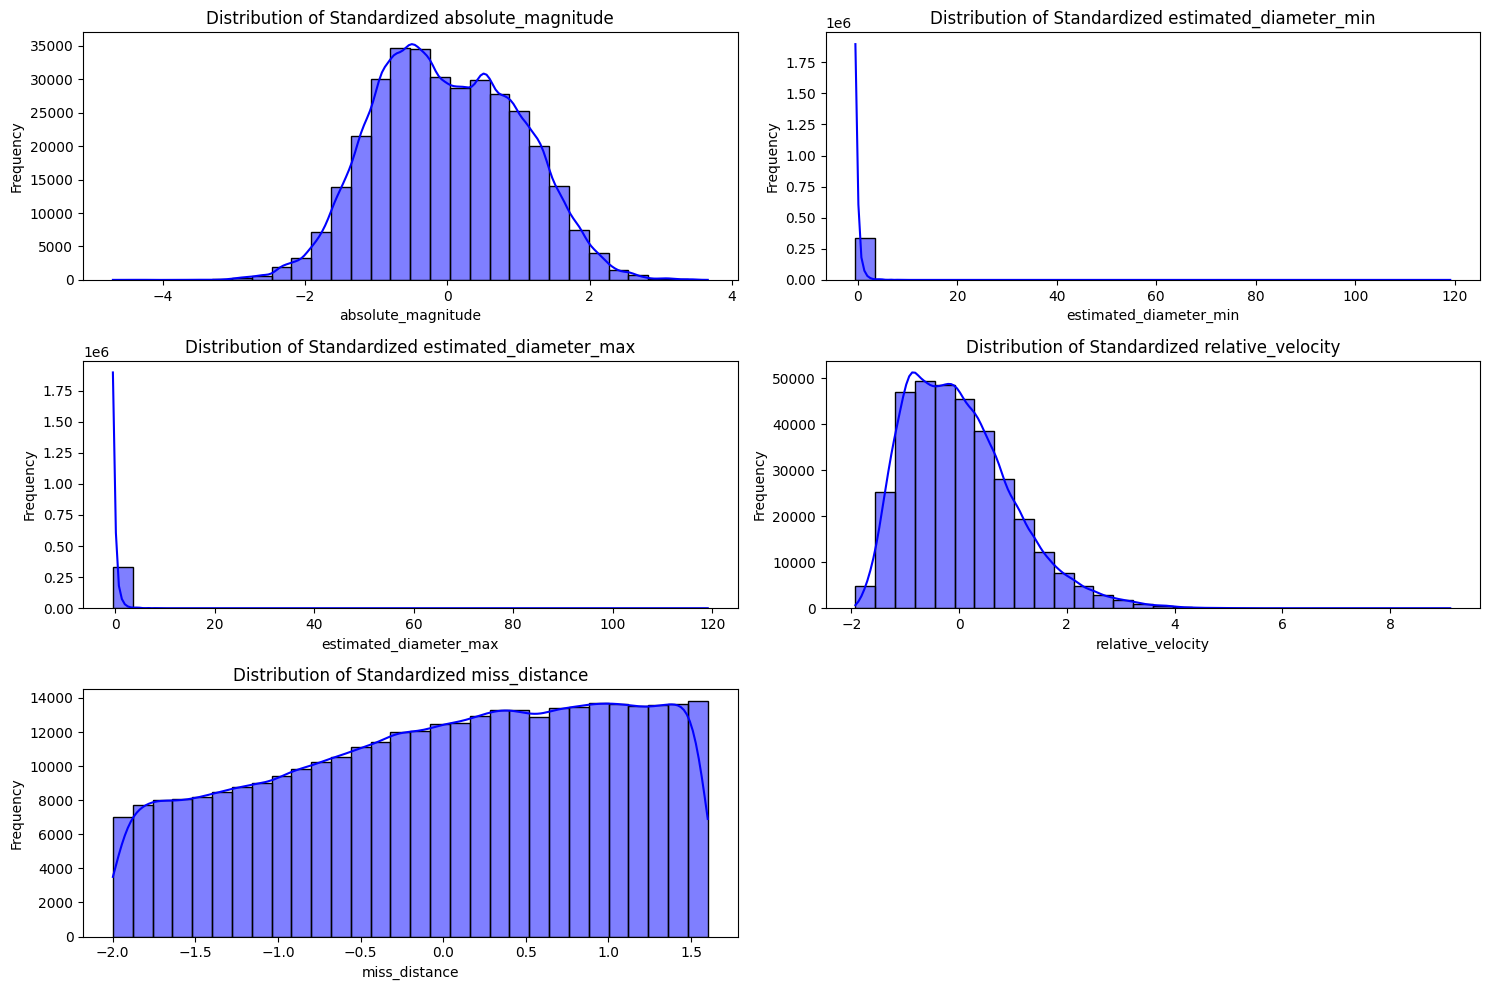

In [15]:
# Distribution of all standardized features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(X_scaled[:, i-1], kde=True, color='blue', bins=30)
    plt.title(f"Distribution of Standardized {feature}")
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

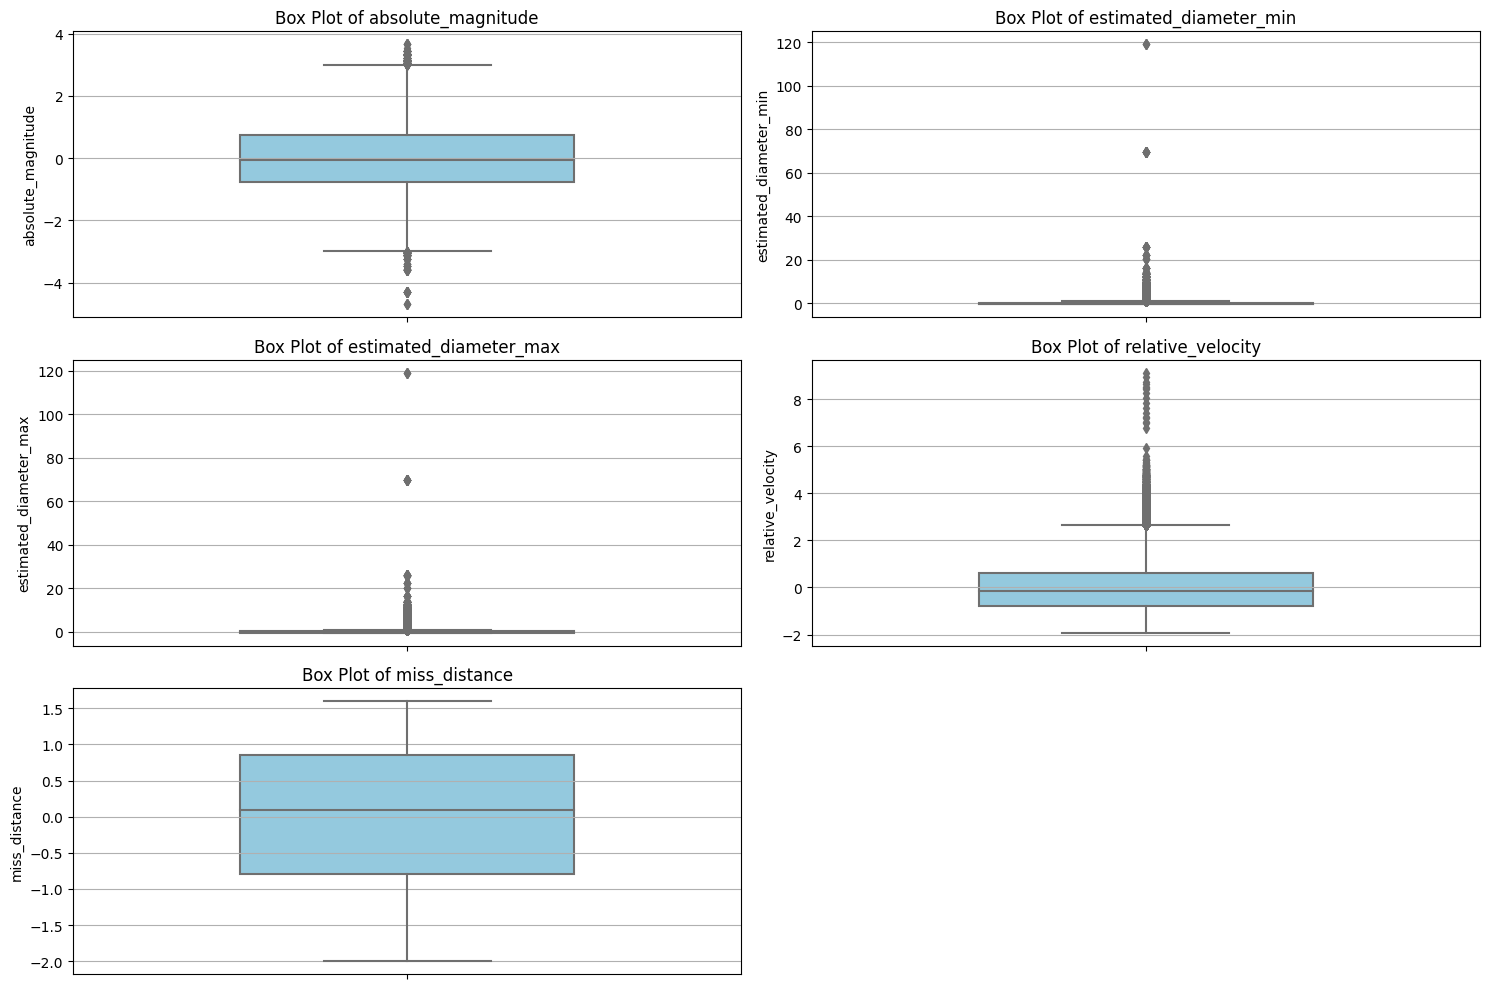

In [17]:
# Plot box plots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=X_scaled[:, i-1], color='skyblue', width=0.5)
    plt.title(f"Box Plot of {feature}")
    plt.ylabel(feature)
    plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
# Split data into training and testing sets
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)

print(f"Training Set Size: {X_train.shape[0]}, Testing Set Size: {X_test.shape[0]}")


Training Set Size: 236719, Testing Set Size: 101452


## 3. Isolation Forest

In [33]:
# Train Isolation Forest on the training set
isolation_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.01,
    random_state=42
)
isolation_forest.fit(X_train)

IsolationForest(contamination=0.01, random_state=42)

In [34]:
# Predict on both training and testing sets
train_outliers_if = isolation_forest.predict(X_train)
test_outliers_if = isolation_forest.predict(X_test)

In [35]:
# Convert predictions to binary (1: inlier, -1: outlier)
train_outliers_if = (train_outliers_if == -1).astype(int)
test_outliers_if = (test_outliers_if == -1).astype(int)

In [36]:
# Train vs Test Outlier Distribution
print("Isolation Forest - Train Outliers:", sum(train_outliers_if))
print("Isolation Forest - Test Outliers:", sum(test_outliers_if))

Isolation Forest - Train Outliers: 2368
Isolation Forest - Test Outliers: 1008


## 4. Local Outlier Factor

In [37]:
# Train LOF on the training set
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.01,
    novelty=True  # Enable to use LOF for test data
)

lof.fit(X_train)  # Fit on training data

LocalOutlierFactor(contamination=0.01, novelty=True)

In [38]:
# Predict on both training and testing sets
train_outliers_lof = lof.predict(X_train)
test_outliers_lof = lof.predict(X_test)

In [39]:
# Convert predictions to binary (1: inlier, -1: outlier)
train_outliers_lof = (train_outliers_lof == -1).astype(int)
test_outliers_lof = (test_outliers_lof == -1).astype(int)

In [40]:
print("LOF - Train Outliers:", sum(train_outliers_lof))
print("LOF - Test Outliers:", sum(test_outliers_lof))

LOF - Train Outliers: 1987
LOF - Test Outliers: 1148


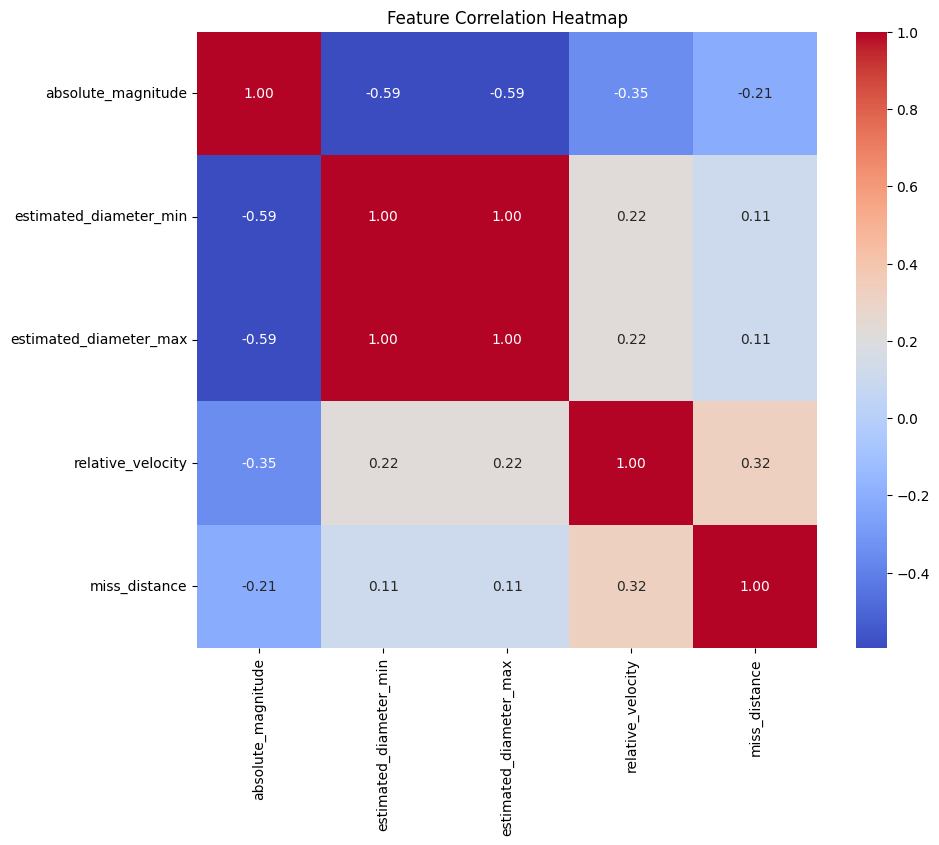

In [42]:
plt.figure(figsize=(10, 8))
correlation_matrix = data[features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


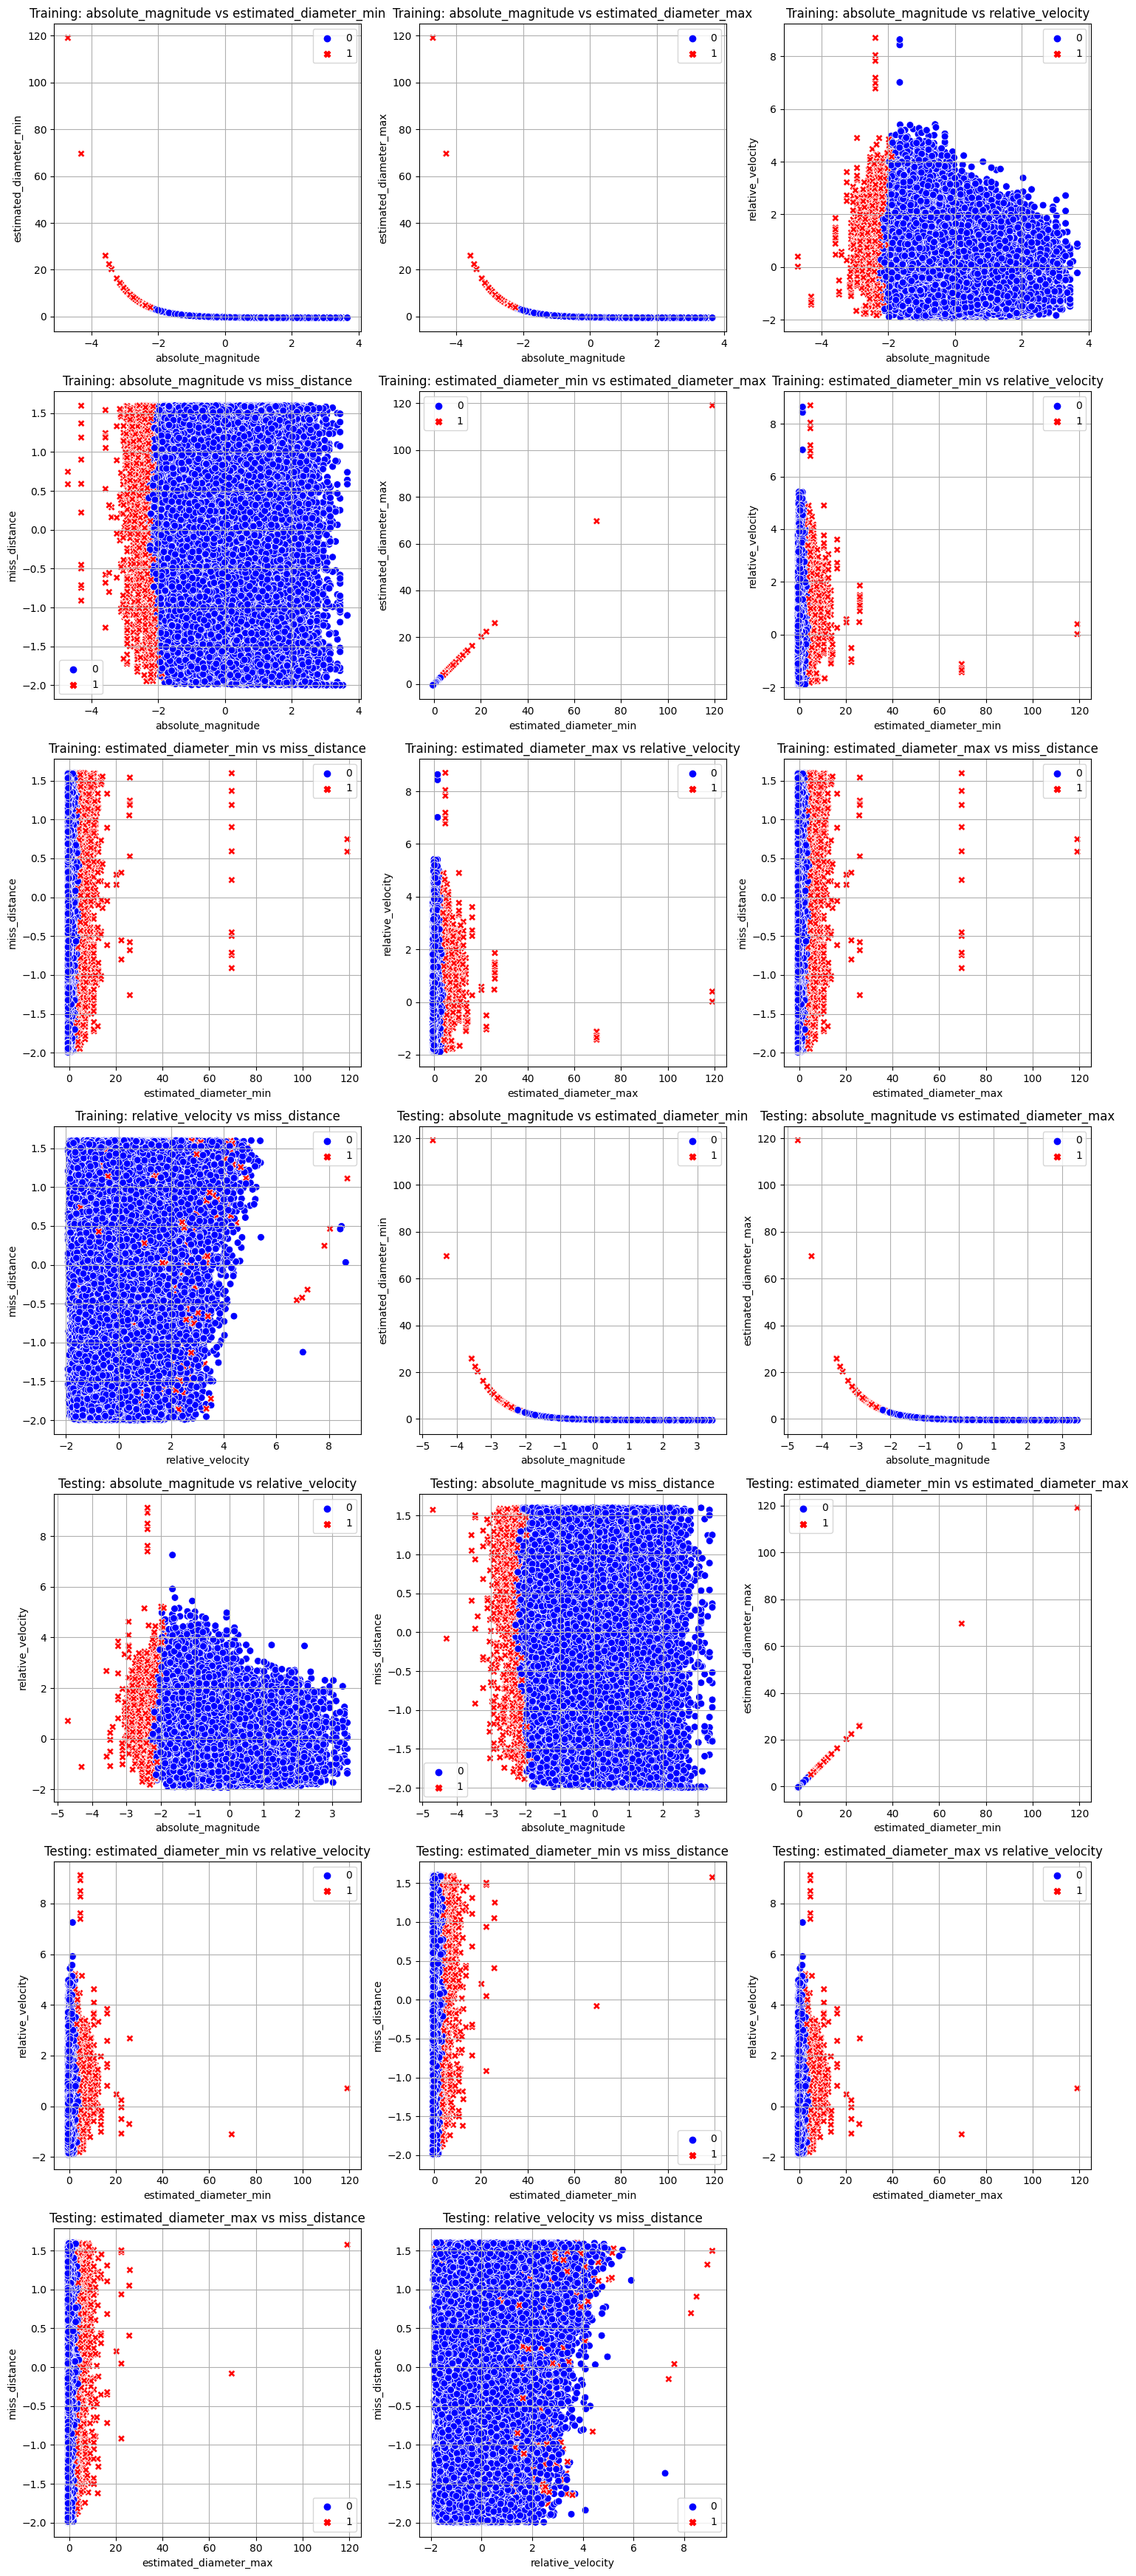

In [ ]:
import itertools

# Create all possible pairs of features
pairs = list(itertools.combinations(range(len(features)), 2))  # Indices of all feature combinations

# Determine the number of rows for subplots
n_cols = 3  # Number of columns for better readability
n_rows = (len(pairs) * 2 + n_cols - 1) // n_cols  # Rows for both train and test

plt.figure(figsize=(n_cols * 5, n_rows * 5))

# Loop through each pair and plot for both training and testing sets
for i, (x_idx, y_idx) in enumerate(pairs):
    # Training set scatter plot
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(
        x=X_train[:, x_idx],
        y=X_train[:, y_idx],
        hue=train_outliers_if,
        palette={0: 'blue', 1: 'red'},
        style=train_outliers_if,
        markers={0: 'o', 1: 'X'},
        s=50
    )
    plt.title(f"Training: {features[x_idx]} vs {features[y_idx]}")
    plt.xlabel(features[x_idx])
    plt.ylabel(features[y_idx])
    plt.grid(True)

    # Testing set scatter plot
    plt.subplot(n_rows, n_cols, i + 1 + len(pairs))
    sns.scatterplot(
        x=X_test[:, x_idx],
        y=X_test[:, y_idx],
        hue=test_outliers_if,
        palette={0: 'blue', 1: 'red'},
        style=test_outliers_if,
        markers={0: 'o', 1: 'X'},
        s=50
    )
    plt.title(f"Testing: {features[x_idx]} vs {features[y_idx]}")
    plt.xlabel(features[x_idx])
    plt.ylabel(features[y_idx])
    plt.grid(True)

plt.tight_layout()
plt.show()


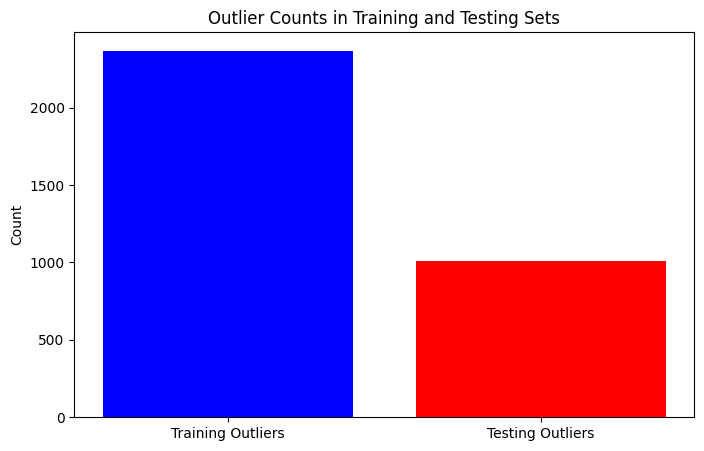

In [45]:
# Outlier counts per feature
train_outlier_counts = (train_outliers_if == 1).sum()
test_outlier_counts = (test_outliers_if == 1).sum()

plt.figure(figsize=(8, 5))
plt.bar(["Training Outliers", "Testing Outliers"], [train_outlier_counts, test_outlier_counts], color=['blue', 'red'])
plt.title("Outlier Counts in Training and Testing Sets")
plt.ylabel("Count")
plt.show()

## 5. IQR Method

In [49]:
# Calculate Q1, Q3, and IQR for each feature
Q1 = np.percentile(X_train, 25, axis=0)
Q3 = np.percentile(X_train, 75, axis=0)
IQR = Q3 - Q1

# Calculate the outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in training set
outliers_iqr = ((X_train < lower_bound) | (X_train > upper_bound)).any(axis=1)
print(f"Number of outliers detected using IQR in training set: {outliers_iqr.sum()}")

# Similarly for the test set
outliers_iqr_test = ((X_test < lower_bound) | (X_test > upper_bound)).any(axis=1)
print(f"Number of outliers detected using IQR in testing set: {outliers_iqr_test.sum()}")


Number of outliers detected using IQR in training set: 21001
Number of outliers detected using IQR in testing set: 8938


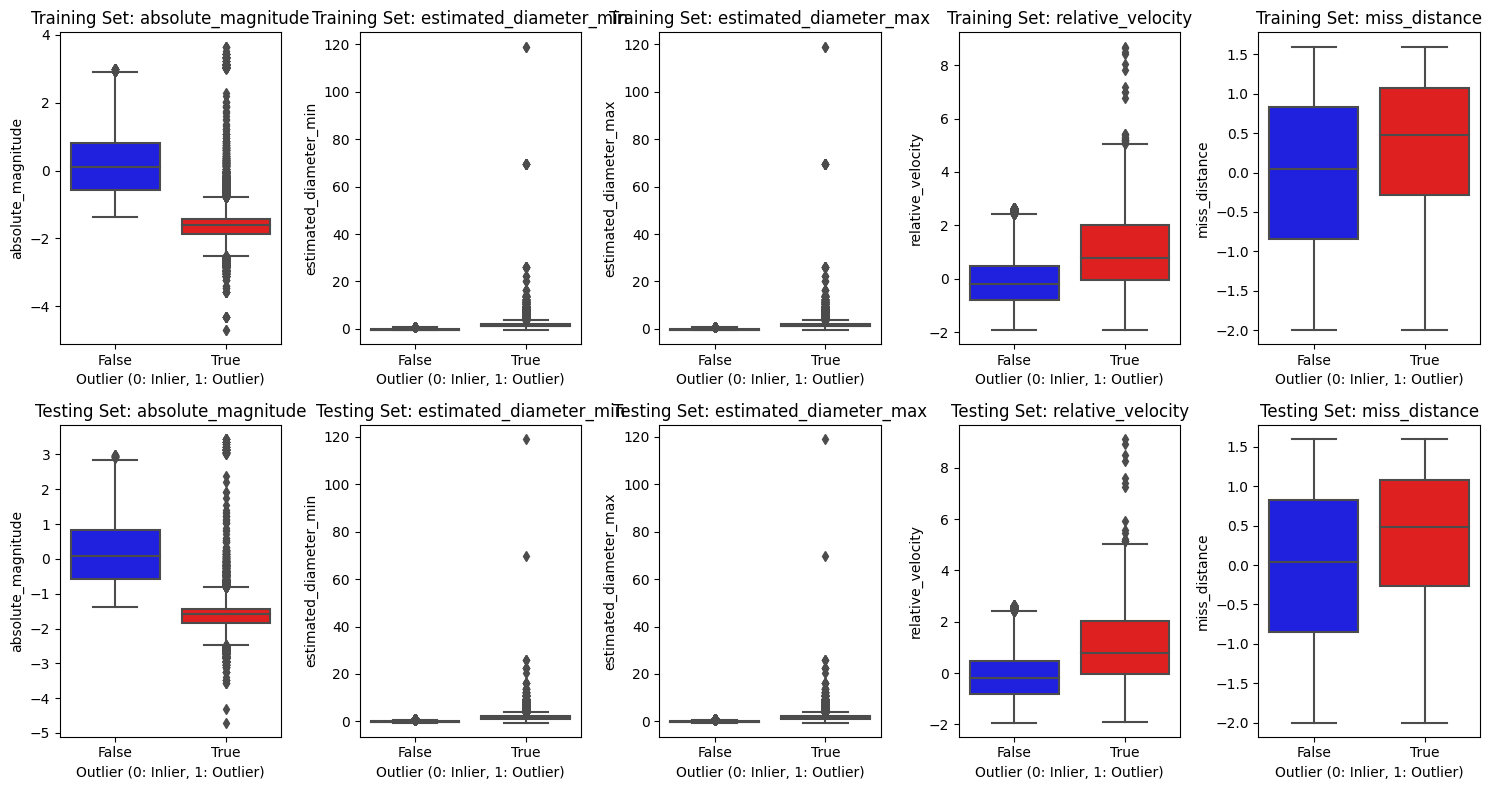

In [50]:
plt.figure(figsize=(15, 8))

# Training set box plot for all features
for i, feature in enumerate(features, 1):
    plt.subplot(2, len(features), i)
    sns.boxplot(x=outliers_iqr, y=X_train[:, i - 1], palette={0: 'blue', 1: 'red'})
    plt.title(f"Training Set: {feature}")
    plt.xlabel("Outlier (0: Inlier, 1: Outlier)")
    plt.ylabel(feature)

# Testing set box plot for all features
for i, feature in enumerate(features, 1):
    plt.subplot(2, len(features), i + len(features))
    sns.boxplot(x=outliers_iqr_test, y=X_test[:, i - 1], palette={0: 'blue', 1: 'red'})
    plt.title(f"Testing Set: {feature}")
    plt.xlabel("Outlier (0: Inlier, 1: Outlier)")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()